# Explore distribution of input duration

In [94]:
import os
import math
import numpy as np
import pandas as pd
from ast import literal_eval
import pymc3
import itertools
import arviz as az
import scipy.stats as st
import scipy.special as sps
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
pd.options.mode.chained_assignment = None  # default='warn'

from helper_functions import *

## Putting all button presses in a single dataframe

Humen sensorimotor system doesn't have capability of pressing a button for only a 60th of a secong (ingame FPS). We need to find out granularity of motor control regadring button pressing to transfer capability to out computational model. Only when it matches the human in that, it can actually engange in dynamic decision-making like humans.

In [ ]:
root_dir = os.getcwd()

data_dir = "/experimental_data/"
done_string = "done"
crashed_string = "crashed"
target_string = "output"

runs = []

for subdir, dirs, files in os.walk(root_dir+data_dir):
    for file in files:
        if done_string in file:
            runs.append(file)
        if crashed_string in file:
            runs.append(file)


snippets = []

for file_name in runs:
    temp = file_name.split("_")
    code = temp[0]
    exp_trial = temp[-1]
    exp_trial = exp_trial[:2]  # cut off .csv
    
    snippets.append([code, exp_trial])
    
temp_df = pd.DataFrame(snippets, columns = ['code', 'trial'])
temp_df

In [ ]:

button_press_data = pd.DataFrame()


for id_code in np.unique(temp_df.code):
    experimental_runs = list(temp_df.loc[temp_df['code'] == id_code].trial)
    
    path = root_dir + data_dir + str(id_code) + "/data"
    for subdir, dirs, files in os.walk(path):
        for data_file in files:
            if ".csv" in str(data_file):

                temp = str(data_file).split("_")
                # extract features of run from file_name coding
                level = temp[2][0]
                drift = temp[2][1]
                input_noise = temp[2][2]
                exp_trial = temp[-1]
                exp_trial = exp_trial[:2]
                done = temp[3]
                
                if done == "crashed":
                    done_bool = False
                elif done == "done":
                    done_bool = True
                                         
                opened_file = pre_process_input_data(pd.read_csv((f"experimental_data/{id_code}/data/{data_file}"), index_col=False))
                                
                frames_with_input = opened_file[opened_file.start_input == 1]
                
                for index, row in frames_with_input.iterrows():
                    
                    # writing to a temporal data frame
                    temp_data = pd.DataFrame({'ID': id_code,
                                              'level': level,
                                              'drift': drift,
                                              'input_noise': input_noise, 
                                              'done': done_bool,
                                              'run': exp_trial, 
                                              'SoC': opened_file["SoC"].iloc[-1],
                                              'N_input': row.N_input,
                                              'current_input': row.current_input,
                                              'input_duration': row.input_duration,
                                              'time_played': row.time_played,
                                              'adjusted_time_tag': row.adjusted_time_tag,
                                              'visible_obstacles': [row.visible_obstacles],
                                              'visible_drift_tiles': [row.visible_drift_tiles]
                                             })
                    
                    button_press_data = pd.concat([button_press_data, temp_data])
                               

#button_press_data
#button_press_data.to_csv('input_data.csv', sep=',')


## Actual data analysis

In [20]:
data = pd.read_csv('input_data/input_data.csv', index_col=False)
data = data.drop(labels=['Unnamed: 0'], axis='columns')

# Two columns actually are strings but are supposed to be arrays of (arrays of) ints. 
# We will literal_eval them
data.visible_obstacles = data.visible_obstacles.apply(lambda row: literal_eval(row))
data.visible_drift_tiles = data.visible_drift_tiles.apply(lambda row: literal_eval(row))

data

,ID,level,drift,input_noise,done,run,SoC,N_input,current_input,input_duration,time_played,adjusted_time_tag,visible_obstacles,visible_drift_tiles,player_pos_x,player_pos_y
0,AE07EM1,3,T,N,True,9,6.0,1.0,Left,0.151958,4.283866,6456.223871,"[[792, 522], [990, 648]]",[],954,270
1,AE07EM1,3,T,N,True,9,6.0,2.0,Right,0.150111,5.424641,6457.364646,"[[852, 120], [1050, 246], [924, 588]]",[],954,270
2,AE07EM1,3,T,N,True,9,6.0,3.0,Right,0.262920,6.186887,6458.126892,"[[864, 324], [882, 558], [684, 792]]","[[504, 570]]",954,270
3,AE07EM1,3,T,N,True,9,6.0,4.0,Left,0.961729,7.036894,6458.976899,"[[759, 36], [777, 270], [579, 504], [939, 648]]","[[408, 282]]",954,270
4,AE07EM1,3,T,N,True,9,6.0,5.0,Right,0.116162,8.743207,6460.683212,"[[1137, 60], [1101, 294], [1245, 438], [903, 5...","[[597, 666]]",954,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31828,ZC12VE,2,F,W,True,45,7.0,6.0,Right,0.307747,19.704680,22401.716427,"[[1040, 96], [1112, 132], [842, 186], [1220, 5...",[],954,270
31829,ZC12VE,2,F,W,True,45,7.0,7.0,Left,0.116736,27.599804,22409.611551,[],[],954,270
31830,ZC12VE,2,F,W,True,45,7.0,8.0,Left,0.168258,29.201920,22411.213666,"[[1001, 528]]",[],954,270
31831,ZC12VE,2,F,W,True,45,7.0,9.0,Left,0.129563,32.362794,22414.374540,"[[1029, 540], [1281, 756]]",[],954,270


In [155]:
data['N_visible_obstacles'] = data.visible_obstacles.apply(lambda row: len(row))
data['N_visible_drift_tiles'] = data.visible_drift_tiles.apply(lambda row: len(row))

In [157]:
data
data.to_csv('input_data/input_data.csv', sep=',')

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_2409/1053065635.py:25: RuntimeWarning: divide by zero encountered in power
  y = bins**(shape-1)*(np.exp(-bins/scale) / (sps.gamma(shape)*scale**shape))


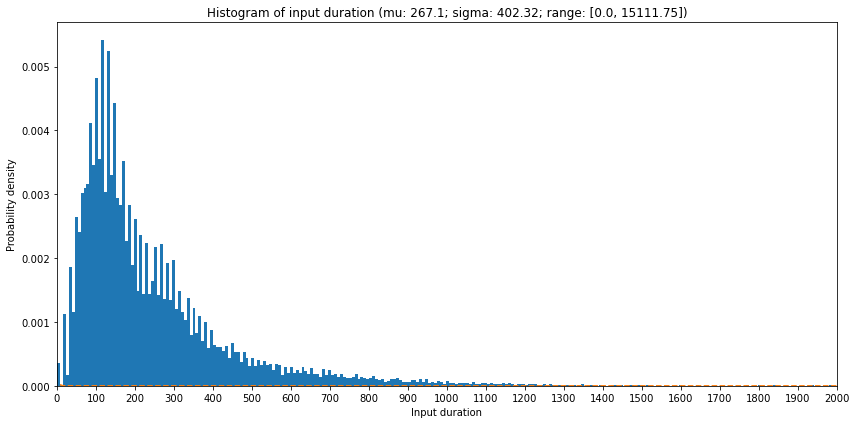

In [131]:
input_duration_in_ms = [i * 1000 for i in data.input_duration]
input_duration_in_ms = [x for x in input_duration_in_ms if ~np.isnan(x)]

mu = np.nanmean(input_duration_in_ms)
sigma = np.nanstd(input_duration_in_ms)
minimum = np.nanmin(input_duration_in_ms)
maximum = np.nanmax(input_duration_in_ms)


num_bins = 2000

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlim([-0.1, 2000])
#ax.set_ylim([0, 5])

xaxis = np.linspace(0, 2000, 21)
ax.set_xticks(xaxis)

# the histogram of the data
n, bins, patches = ax.hist(input_duration_in_ms, num_bins, density=True)

# add a 'best fit' line
shape, loc, scale = st.gamma.fit(input_duration_in_ms)
y = bins**(shape-1)*(np.exp(-bins/scale) / (sps.gamma(shape)*scale**shape))
#y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--', alpha=1.0)

#shape, loc, scale = st.gamma.fit(data.input_duration)
#y = bins**(shape-1)*(np.exp(-bins/scale) / (sps.gamma(shape)*scale**shape))

ax.set_xlabel('Input duration')
ax.set_ylabel('Probability density')
ax.set_title(f'Histogram of input duration (mu: {round(mu, 2)}; sigma: {round(sigma, 2)}; range: [{round(minimum, 2)}, {round(maximum, 2)}])')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [60]:
# where to cut off max

len(data[data.input_duration > 10])  # 5
len(data[data.input_duration > 5])  # 34
len(data[data.input_duration > 2])  # 223
len(data[data.input_duration > 2.45])  # 173 
# -> 2.45s is the time an obstacle takes to appear at bottom and disappear at top again

173

In [56]:
# where to cut off min

# duration of 2 frames
(1/60) * 2  # 0.03333333333333333

len(data[data.input_duration < 0.1])  # 6792
len(data[data.input_duration < 0.05]) # 1472
len(data[data.input_duration < 0.02]) # 324
len(data[data.input_duration < 0.017]) # 265
len(data[data.input_duration < 0.033]) # 537 -> input has to at least last for 2 frames

537

In [134]:
filtered_input_duration = data[(data.input_duration > 0.033) & (data.input_duration < 2.45)].input_duration
#filtered_input_duration_in_ms = [i * 1000 for i in filtered_input_duration]

0.8109408034890033 0.033000469207763596 0.26542743345004116
0.1


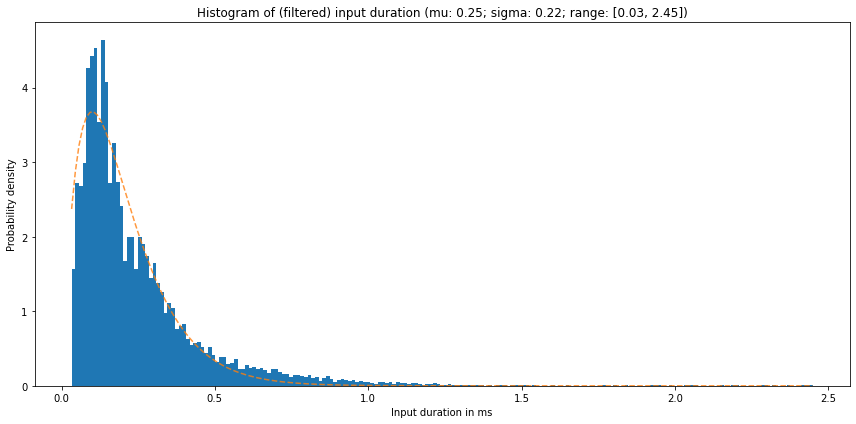

In [154]:
mu = np.nanmean(filtered_input_duration)
sigma = np.nanstd(filtered_input_duration)
minimum = np.nanmin(filtered_input_duration)
maximum = np.nanmax(filtered_input_duration)


num_bins = 201

fig, ax = plt.subplots(figsize=(12, 6))

#ax.set_xlim([-0.05, 2.5])
#ax.set_ylim([0, 5])

#xaxis = np.linspace(0, 2.5, 21)
#ax.set_xticks(xaxis)

# the histogram of the data
n, bins, patches = ax.hist(filtered_input_duration, num_bins, density=True)

# add a 'best fit' line
#y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#ax.plot(bins, y, '--', alpha=0.4)

shape, loc, scale = st.gamma.fit(filtered_input_duration)
print(shape, loc, scale)
shape = 1.250509
shape = 2
rate = 5.017894
rate = 10
scale = 1/rate
print(scale)
y = bins**(shape-1)*(np.exp(-bins/scale) / (sps.gamma(shape)*scale**shape))

#rv = st.gamma(filtered_input_duration)
ax.plot(bins, y, '--', alpha=0.8, label='gamma pdf')
#ax.plot(bins, st.gamma.pdf(bins, shape), '--', alpha=0.4, label='gamma pdf')

ax.set_xlabel('Input duration in ms')
ax.set_ylabel('Probability density')
ax.set_title(f'Histogram of (filtered) input duration (mu: {round(mu, 2)}; sigma: {round(sigma, 2)}; range: [{round(minimum, 2)}, {round(maximum, 2)}])')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()